In [1]:
# Importing required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import DistanceMetric

import warnings

sns.set()
warnings.filterwarnings("ignore")
import json


In [65]:
with open(r'acn.json', 'r') as jf:
    ev = json.load(jf)
       
# Flatten data
df = pd.json_normalize(ev, record_path =['_items'])
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None


In [69]:
df['userID'].value_counts()

000000743    485
000000562    385
000001082    383
000001746    315
000001470    315
            ... 
000004591      1
000000394      1
000000393      1
000000459      1
000019869      1
Name: userID, Length: 571, dtype: int64

In [3]:
#Initial Data Preprocessing Steps
df_pre=df
def date_conversion(col):     
    date_connection_time = pd.to_datetime(df_pre[col], format="%a, %d %b %Y %X %Z")
    date_format_connect = date_connection_time.dt.tz_localize(None)
    connect_date = date_format_connect.dt.date
    df_pre[col] = connect_date
    df_pre[col]=df_pre[col].astype('datetime64[ns]')
df_pre['doneChargingTime'].fillna(df_pre['disconnectTime'],inplace=True) # Fill Null values
date_conversion('connectionTime')
date_conversion('disconnectTime')
date_conversion('doneChargingTime')
def ev_univ(input_col,pred_col):
    ev_univ = df_pre[[input_col,pred_col]]
    ev_univ_agg = ev_univ.groupby([input_col]).agg({pred_col:np.sum})
    return ev_univ_agg
uni_done = ev_univ('doneChargingTime','kWhDelivered')
uni_conn = ev_univ('connectionTime','kWhDelivered')
uni_disconn = ev_univ('disconnectTime','kWhDelivered')
uni_2=uni_disconn.reset_index()
df_1=uni_2
df_1

,disconnectTime,kWhDelivered
0,2018-04-25,151.103
1,2018-04-26,385.389
2,2018-04-27,409.963
3,2018-04-28,540.545
4,2018-04-29,267.643
...,...,...
1074,2021-09-10,393.768
1075,2021-09-11,315.598
1076,2021-09-12,179.279
1077,2021-09-13,368.374


In [4]:
#Importing Date Lookup table
      
# Flatten data
date_df = pd.read_csv(r'date_lookup.csv')
date_df.head()

,Date,Year,Month,Day
0,25-Apr-2018,2018,4,25
1,26-Apr-2018,2018,4,26
2,27-Apr-2018,2018,4,27
3,28-Apr-2018,2018,4,28
4,29-Apr-2018,2018,4,29


In [5]:
#Lookup Table processing
date_df['Date'] = date_df['Date'].astype('datetime64')
date_df.set_index('Date')
merge=pd.merge(date_df,df_1, how='left',left_on='Date',right_on='disconnectTime')
merge['day_of_week'] = merge['Date'].dt.weekday
merge["IsWeekend"] = merge["day_of_week"] >= 5
analy = merge[['Date','kWhDelivered']]
analy_weekend = merge[['Date','IsWeekend','kWhDelivered']]
analy_1=analy.set_index('Date')
analy_weekend_1=analy_weekend.set_index('Date')
#KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df = pd.DataFrame(imputer.fit_transform(analy_weekend_1),columns = analy_weekend_1.columns)
#Concatenating date lookup and source data
x1=pd.concat([analy_weekend,df], axis=1, ignore_index=True)
final=x1
final.drop(3,axis=1,inplace=True)
final.drop(2,axis=1,inplace=True)
final_df=final.rename(columns={0:'Date',1: "IsWeekend", 4: "kWhDelivered"})


In [6]:
final_df

,Date,IsWeekend,kWhDelivered
0,2018-04-25,False,151.103
1,2018-04-26,False,385.389
2,2018-04-27,False,409.963
3,2018-04-28,True,540.545
4,2018-04-29,True,267.643
...,...,...,...
1234,2021-09-10,False,393.768
1235,2021-09-11,True,315.598
1236,2021-09-12,True,179.279
1237,2021-09-13,False,368.374


In [7]:
final_df['Date'] = pd.to_datetime(final_df.Date)
final_df['day_of_week'] = final_df.Date.dt.weekday

In [8]:
final_df

,Date,IsWeekend,kWhDelivered,day_of_week
0,2018-04-25,False,151.103,2
1,2018-04-26,False,385.389,3
2,2018-04-27,False,409.963,4
3,2018-04-28,True,540.545,5
4,2018-04-29,True,267.643,6
...,...,...,...,...
1234,2021-09-10,False,393.768,4
1235,2021-09-11,True,315.598,5
1236,2021-09-12,True,179.279,6
1237,2021-09-13,False,368.374,0


In [9]:
final_df['day_of_week_sin'] = np.sin(final_df['day_of_week'] * (2 * np.pi / 7))
final_df['day_of_week_cos'] = np.cos(final_df['day_of_week'] * (2 * np.pi / 7))

In [10]:
uni_3=final_df
uni_3=uni_3.set_index('Date')
uni_3.index.freq = 'D'
uni_3_filter=uni_3['kWhDelivered']
uni_3.rename(columns={'kWhDelivered':'Kwh'},inplace=True)
# uni_3_filter = uni_3
# uni_3_filter = uni_3_filter.drop('IsWeekend',axis=1,inplace=True)
data=uni_3 # Data for forecastinng

In [11]:
data

,IsWeekend,Kwh,day_of_week,day_of_week_sin,day_of_week_cos
Date,,,,,
2018-04-25,False,151.103,2,0.974928,-0.222521
2018-04-26,False,385.389,3,0.433884,-0.900969
2018-04-27,False,409.963,4,-0.433884,-0.900969
2018-04-28,True,540.545,5,-0.974928,-0.222521
2018-04-29,True,267.643,6,-0.781831,0.623490
...,...,...,...,...,...
2021-09-10,False,393.768,4,-0.433884,-0.900969
2021-09-11,True,315.598,5,-0.974928,-0.222521
2021-09-12,True,179.279,6,-0.781831,0.623490


In [12]:
# data['Kwh_differ']=data['Kwh'].shift(-1)
data['Kwh_differ']=data['Kwh'].shift(-7)

In [13]:
data=data.dropna()
data

,IsWeekend,Kwh,day_of_week,day_of_week_sin,day_of_week_cos,Kwh_differ
Date,,,,,,
2018-04-25,False,151.103,2,0.974928,-0.222521,414.264000
2018-04-26,False,385.389,3,0.433884,-0.900969,538.226000
2018-04-27,False,409.963,4,-0.433884,-0.900969,593.196722
2018-04-28,True,540.545,5,-0.974928,-0.222521,552.874297
2018-04-29,True,267.643,6,-0.781831,0.623490,312.118000
...,...,...,...,...,...,...
2021-09-03,False,163.255,4,-0.433884,-0.900969,393.768000
2021-09-04,True,241.266,5,-0.974928,-0.222521,315.598000
2021-09-05,True,236.295,6,-0.781831,0.623490,179.279000


In [14]:
data

,IsWeekend,Kwh,day_of_week,day_of_week_sin,day_of_week_cos,Kwh_differ
Date,,,,,,
2018-04-25,False,151.103,2,0.974928,-0.222521,414.264000
2018-04-26,False,385.389,3,0.433884,-0.900969,538.226000
2018-04-27,False,409.963,4,-0.433884,-0.900969,593.196722
2018-04-28,True,540.545,5,-0.974928,-0.222521,552.874297
2018-04-29,True,267.643,6,-0.781831,0.623490,312.118000
...,...,...,...,...,...,...
2021-09-03,False,163.255,4,-0.433884,-0.900969,393.768000
2021-09-04,True,241.266,5,-0.974928,-0.222521,315.598000
2021-09-05,True,236.295,6,-0.781831,0.623490,179.279000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1232 entries, 2018-04-25 to 2021-09-07
Freq: D
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IsWeekend        1232 non-null   bool   
 1   Kwh              1232 non-null   float64
 2   day_of_week      1232 non-null   int64  
 3   day_of_week_sin  1232 non-null   float64
 4   day_of_week_cos  1232 non-null   float64
 5   Kwh_differ       1232 non-null   float64
dtypes: bool(1), float64(4), int64(1)
memory usage: 59.0 KB


In [16]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=5, random_state=1)

In [17]:
import numpy as np
x1,x2,x3,x4,x5,y=data['Kwh_differ'],data['IsWeekend'],data['day_of_week'],data['day_of_week_sin'],data['day_of_week_cos'],data['Kwh'] # pandas dataframce
x1,x2,x3,x4,x5,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(y) # array
x1,x2,x3,x4,x5,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3,x4,x5),axis=1)
print(final_x)

[[ 4.14264000e+02  0.00000000e+00  2.00000000e+00  9.74927912e-01
  -2.22520934e-01]
 [ 5.38226000e+02  0.00000000e+00  3.00000000e+00  4.33883739e-01
  -9.00968868e-01]
 [ 5.93196722e+02  0.00000000e+00  4.00000000e+00 -4.33883739e-01
  -9.00968868e-01]
 ...
 [ 1.79279000e+02  1.00000000e+00  6.00000000e+00 -7.81831482e-01
   6.23489802e-01]
 [ 3.68374000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 2.57535000e+02  0.00000000e+00  1.00000000e+00  7.81831482e-01
   6.23489802e-01]]


In [18]:
X_train,X_test,y_train,y_test=final_x[:-250],final_x[-250:],y[:-250],y[-250:]

In [19]:
model.fit(X_train,y_train)

RandomForestRegressor(max_features=5, random_state=1)

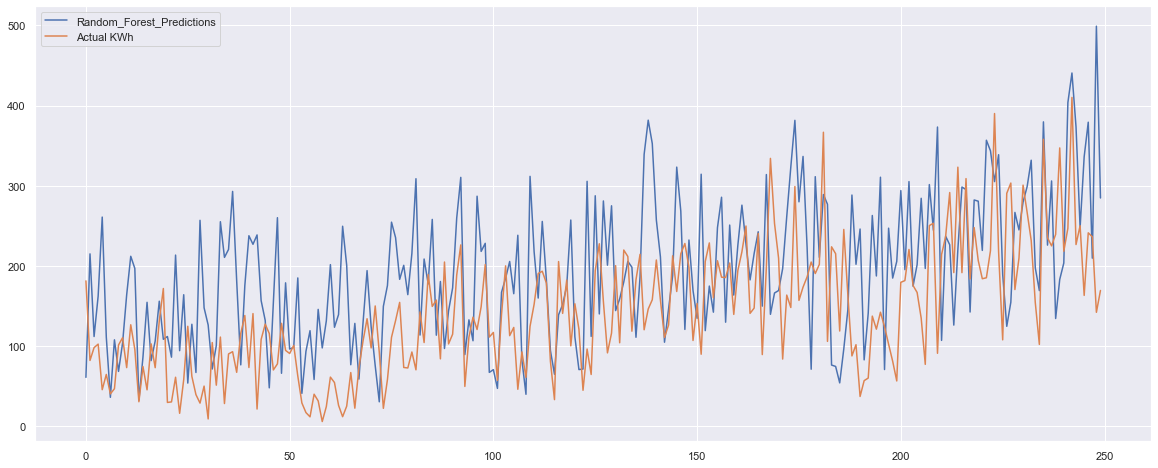

In [20]:
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual KWh')
plt.legend(loc="upper left")
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))


In [22]:
print('Mean Squared Error for Random Forest Model is:',rmse_rf)

Mean Squared Error for Random Forest Model is: 103.85190188467291


In [23]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(objective='reg:squarederror')
model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

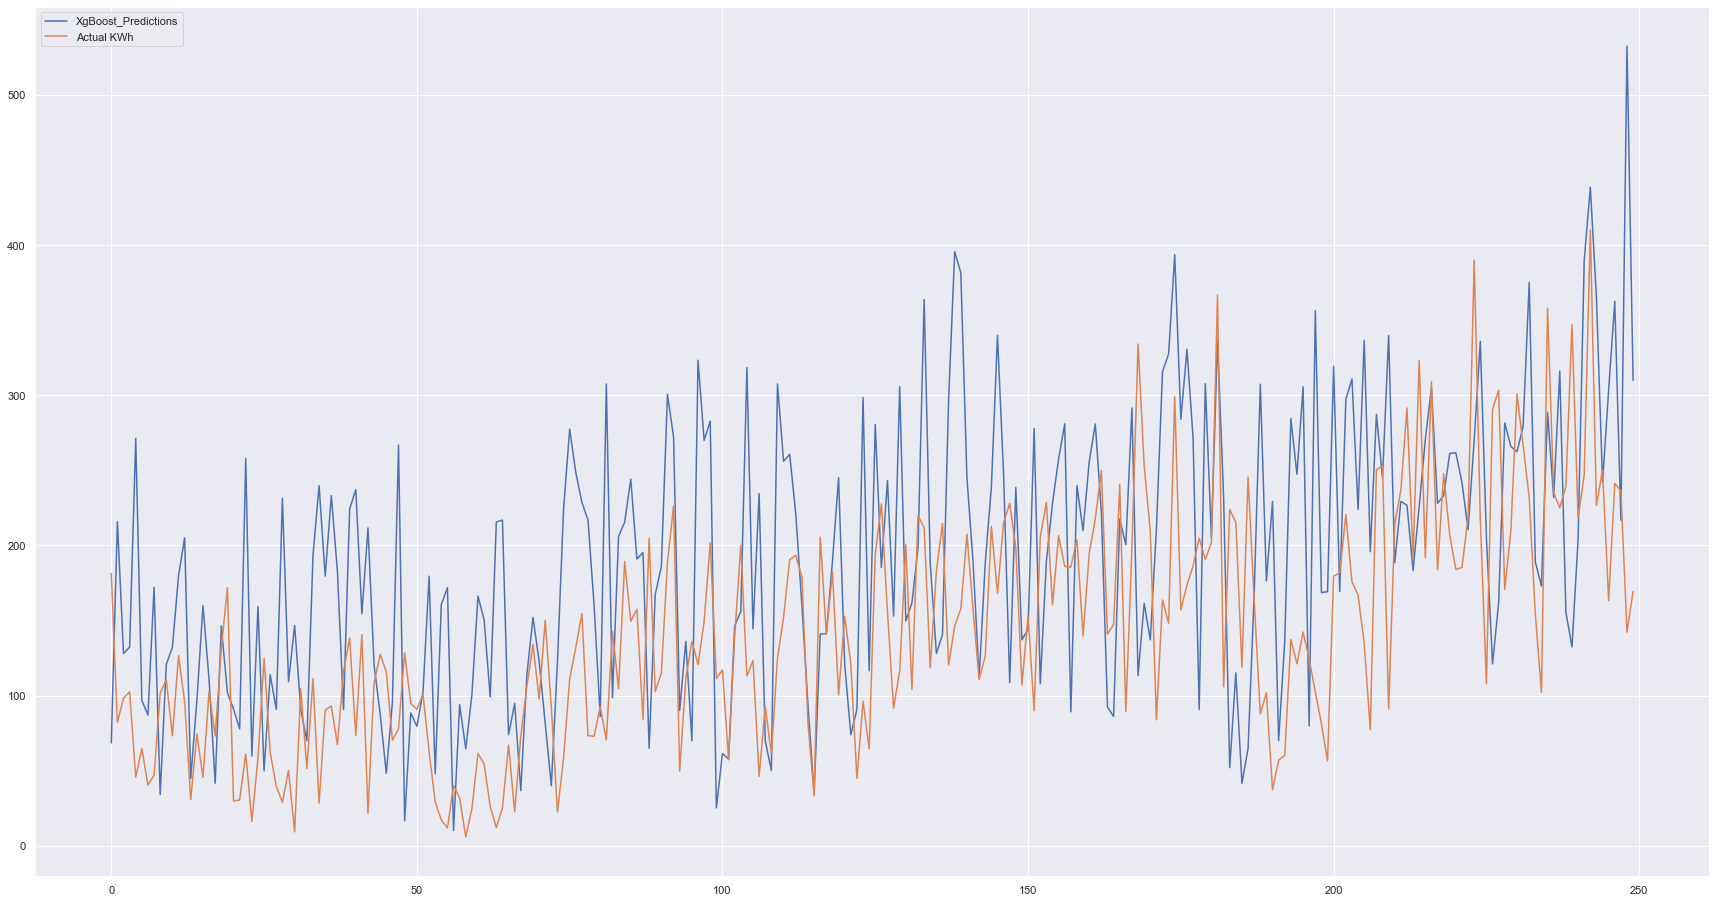

In [24]:
pred_xgb=model_xgb.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,16)
plt.plot(pred_xgb,label='XgBoost_Predictions')
plt.plot(y_test,label='Actual KWh')
plt.legend(loc="upper left")
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb=sqrt(mean_squared_error(pred_xgb,y_test))


In [26]:
print('Mean Squared Error for XGBoost Model is:',rmse_xgb)

Mean Squared Error for XGBoost Model is: 106.4924579321888


In [27]:
X_lgbm, y_lgbm = data.drop("Kwh", axis=1), data[["Kwh"]].values.flatten()

In [28]:
y_lgbm

array([151.103, 385.389, 409.963, ..., 236.295, 142.181, 169.417])

In [29]:
X_train_lgbm,X_test_lgbm,y_train_lgbm,y_test_lgbm=X_lgbm[:-250],X_lgbm[-250:],y_lgbm[:-250],y_lgbm[-250:]

In [30]:
X_train_lgbm

,IsWeekend,day_of_week,day_of_week_sin,day_of_week_cos,Kwh_differ
Date,,,,,
2018-04-25,False,2,0.974928,-0.222521,414.264000
2018-04-26,False,3,0.433884,-0.900969,538.226000
2018-04-27,False,4,-0.433884,-0.900969,593.196722
2018-04-28,True,5,-0.974928,-0.222521,552.874297
2018-04-29,True,6,-0.781831,0.623490,312.118000
...,...,...,...,...,...
2020-12-27,True,6,-0.781831,0.623490,98.165000
2020-12-28,False,0,0.000000,1.000000,102.501000
2020-12-29,False,1,0.781831,0.623490,45.705000


In [60]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(learning_rate=0.04,objective='regression',max_depth=-5,random_state=200)
model_lgb.fit(X_train_lgbm,y_train_lgbm)
# model.fit(X_train_lgbm,y_train_lgbm,eval_set=[(X_test_lgbm,y_test_lgbm),(X_train_lgbm,y_train_lgbm)],
#           verbose=20)

LGBMRegressor(learning_rate=0.04, max_depth=-5, objective='regression',
              random_state=200)

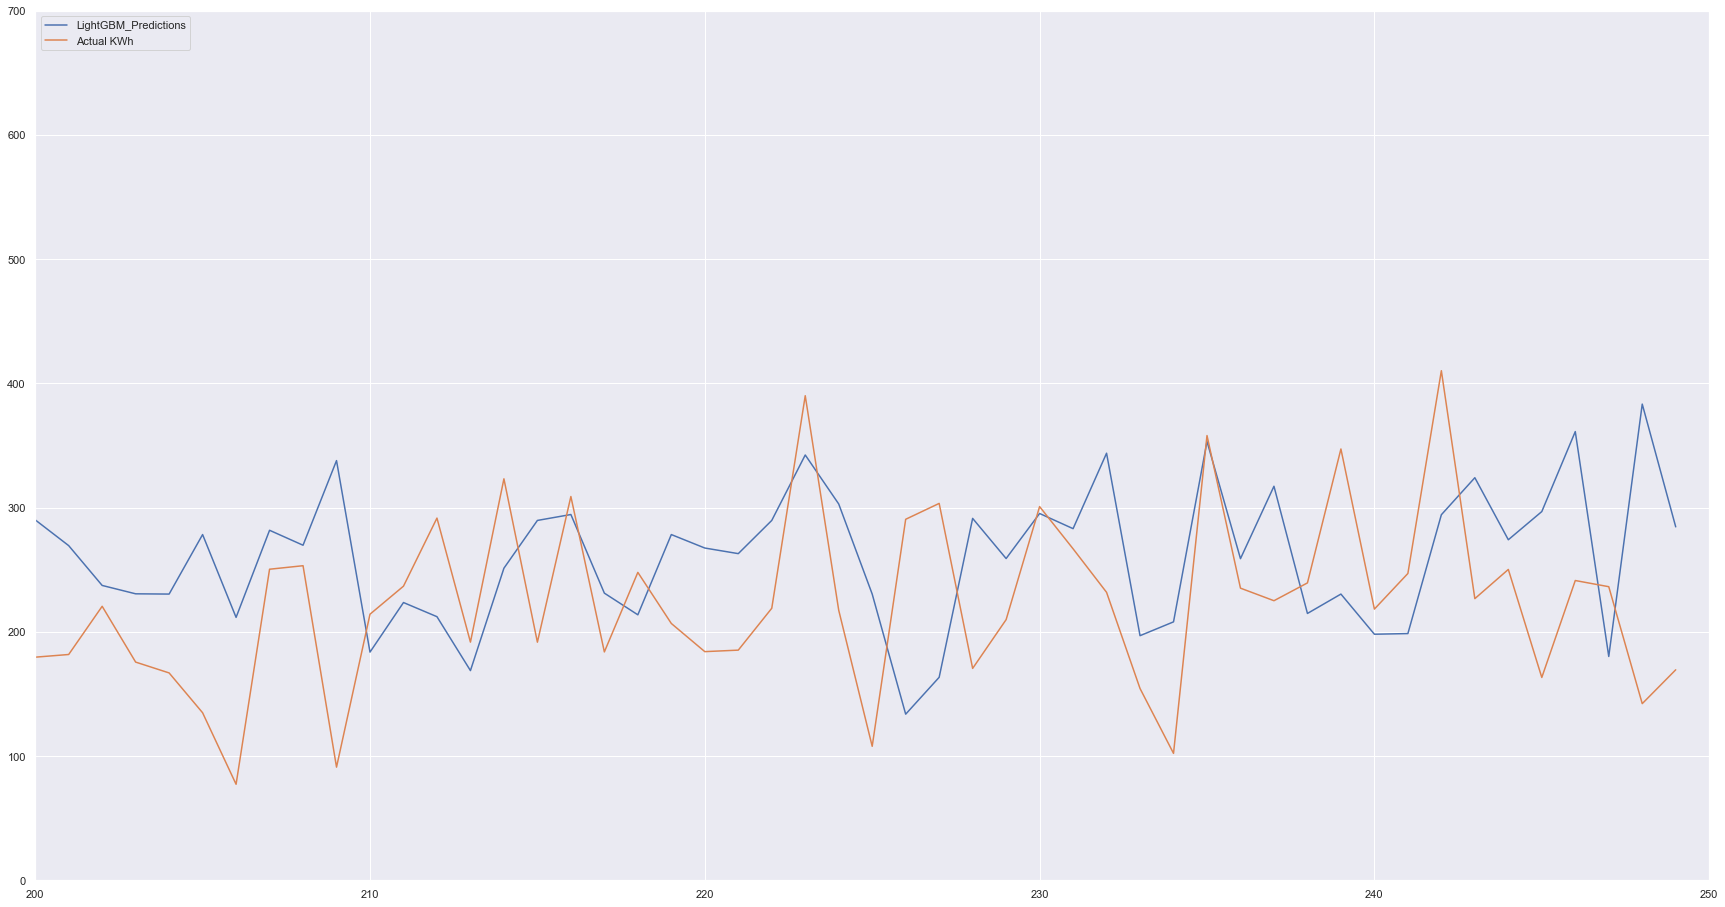

In [61]:
pred_lgb=model_lgb.predict(X_test_lgbm)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,16)
plt.plot(pred_lgb,label='LightGBM_Predictions')
plt.plot(y_test_lgbm,label='Actual KWh')
plt.legend(loc="upper left")
plt.axis([200,250,0,700])
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lgb=sqrt(mean_squared_error(pred_lgb,y_test_lgbm))
print('Mean Squared Error for LGBM Model is:',rmse_lgb)

Mean Squared Error for LGBM Model is: 93.92050579509879


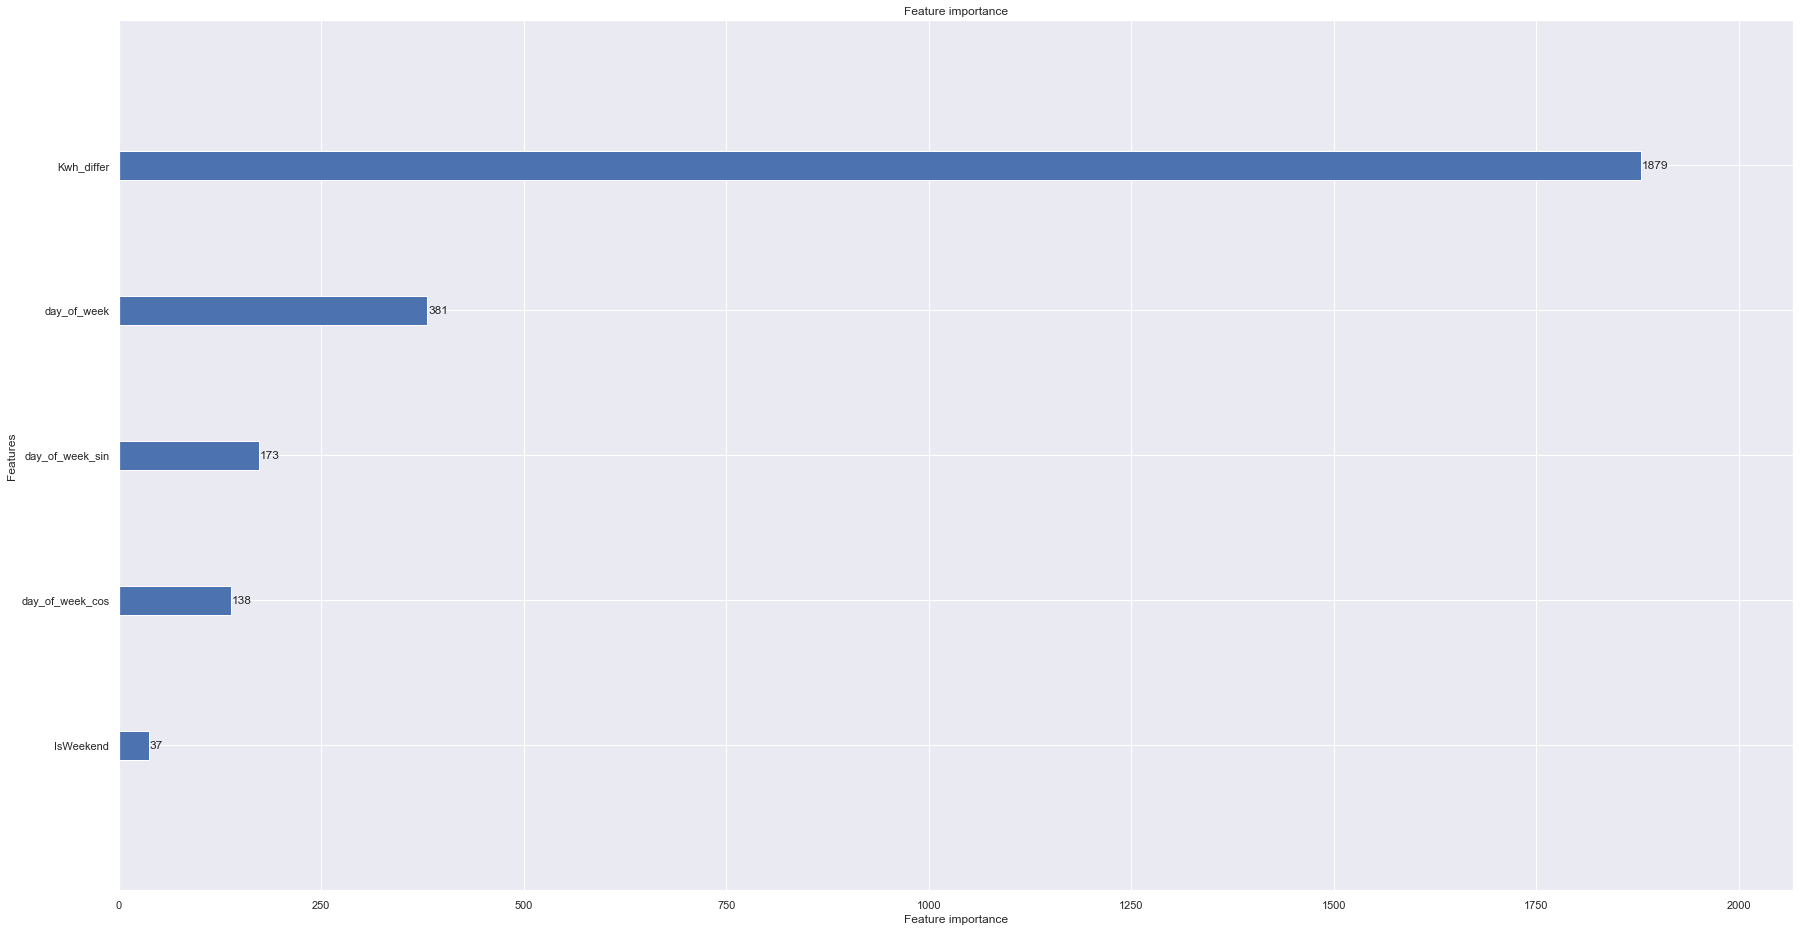

In [34]:
lgb.plot_importance(model_lgb)

In [35]:
# #Hyperparameter Tuning
# #Set the minimum error arbitrarily large
# min = 99999999999999999999999 
# count = 0 #Used for keeping track of the iteration number
# #How many runs to perform using randomly selected hyperparameters
# iterations = 50
# for i in range(iterations):
#     print('iteration number', count)
#     count += 1 #increment count
#     try:
#         d_train = lgb.Dataset(X_train_lgbm, label=y_train_lgbm) #Load in data
#         params = {} #initialize parameters
#         params['learning_rate'] = np.random.uniform(0, 1)
#         params['boosting_type'] = np.random.choice(['gbdt', 'dart', 'goss'])
#         params['objective'] = 'regression'
#         params['metric'] = 'mae'
#         params['sub_feature'] = np.random.uniform(0, 1)
#         params['num_leaves'] = np.random.randint(20, 300)
#         params['min_data'] = np.random.randint(10, 100)
#         params['max_depth'] = np.random.randint(5, 200)
#         iterations = np.random.randint(10, 10000)
#         print(params, iterations)
#         #Train using selected parameters
#         clf = lgb.train(params, d_train, iterations)
#         y_pred=clf.predict(X_test_lgbm) #Create predictions on test set
#         mae=mean_absolute_error(pred_lgb,y_test_lgbm)
#         print('MAE:', mae)
#         if mae < min:
#             min = mae
#             pp = params 
#     except: #in case something goes wrong
#         print('failed with')
#         print(params)
# print("*" * 50)
# print('Minimum is: ', min)
# print('Used params', pp)